## Initial Setup

In [ ]:
%%capture
#%%script false
!pip install shap==0.23.0
!pip install xgboost==0.82
!pip install catboost
!pip install lightgbm==2.2.4
#!pip install tensorboardcolab
!pip install seaborn==0.9.0
!pip install pandas==0.24.2
!pip install numpy==1.16.2
!pip install scikit-optimize==0.6

#Restart Runtime

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

## Data

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plt.rc('figure', figsize=(20.0, 6.0))

import shap
from tqdm import tqdm_notebook as tqdm

#from sklearn.externals import joblib
from sklearn.model_selection import train_test_split
#from sklearn.model_selection import StratifiedShuffleSplit #, RepeatedKFold, StratifiedKFold, RepeatedStratifiedKFold

import xgboost as xgb
import lightgbm as lgb
import catboost as cat

#import sklearn.svm as svm
#import sklearn.neighbors as knn


from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score, auc
from sklearn.metrics import mean_squared_error #, mean_squared_log_error

In [ ]:
train_data_og = pd.read_csv("drive/My Drive/PyColab Work/AV/LTFS - 2/train_data.csv", parse_dates=[0])
sub_data_og = pd.read_csv("drive/My Drive/PyColab Work/AV/LTFS - 2/test_data.csv", parse_dates=[1])

Train data start 2017-Apr-01, end 2019-Jul-23 <- ~3 yr 3 months  
Test data start 2019-Jul-06, end 2019-Oct-24 <- ~4 months  

In [ ]:
# # Change id only
# train_data_og = pd.read_csv("https://drive.google.com/uc?export=download&id=12oxT4vidbxFM_davis5vhudyIGN5Ma5B")
# sub_data_og = pd.read_csv("https://drive.google.com/uc?export=download&id=x6Lwb3dbZ7XR3gd6Uf1OHy")

In [ ]:
train_data_og.head()

,application_date,segment,branch_id,state,zone,case_count
0,2017-04-01,1,1.0,WEST BENGAL,EAST,40.0
1,2017-04-03,1,1.0,WEST BENGAL,EAST,5.0
2,2017-04-04,1,1.0,WEST BENGAL,EAST,4.0
3,2017-04-05,1,1.0,WEST BENGAL,EAST,113.0
4,2017-04-07,1,1.0,WEST BENGAL,EAST,76.0


In [ ]:
sub_data_og.head()

,id,application_date,segment
0,1,2019-07-06,1
1,2,2019-07-07,1
2,3,2019-07-08,1
3,4,2019-07-09,1
4,5,2019-07-10,1


In [ ]:
train_data_og.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80402 entries, 0 to 80401
Data columns (total 6 columns):
application_date    80402 non-null datetime64[ns]
segment             80402 non-null int64
branch_id           66898 non-null float64
state               80402 non-null object
zone                66898 non-null object
case_count          80402 non-null float64
dtypes: datetime64[ns](1), float64(2), int64(1), object(2)
memory usage: 3.7+ MB


In [ ]:
sub_data_og.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180 entries, 0 to 179
Data columns (total 3 columns):
id                  180 non-null int64
application_date    180 non-null datetime64[ns]
segment             180 non-null int64
dtypes: datetime64[ns](1), int64(2)
memory usage: 4.3 KB


In [ ]:
train_data_og.zone.value_counts(dropna=False)

EAST       21762
SOUTH      18538
WEST       16926
NaN        13504
NORTH       8060
CENTRAL     1612
Name: zone, dtype: int64

In [ ]:
train_data_og.branch_id.value_counts(dropna=False)

### Manipulation

Mean Encoding.  
Divide and Multiply columns.  


Time Series  
Date parts  
Lag values  
Difference between dates 

Train data start 2017-Apr-01, end 2019-Jul-23 <- ~3 yr 3 months  
Test data start 2019-Jul-06, end 2019-Oct-24 <- ~4 months  

Branch Id or State are not required in submission. Hence info only.

In [ ]:
branchid = np.unique(train_data_og.query('branch_id == branch_id & segment == 1').branch_id).tolist()

In [ ]:
np.unique(train_data_og.query('branch_id == branch_id & segment == 2').branch_id).tolist()

[]

In [ ]:
zone1 = np.unique(train_data_og.query('zone == zone & segment == 1').zone).tolist()
zone1

['CENTRAL', 'EAST', 'NORTH', 'SOUTH', 'WEST']

In [ ]:
np.unique(train_data_og.query('zone == zone & segment == 2').zone).tolist()

[]

In [ ]:
statelist1 = np.unique(train_data_og.query('state == state & segment == 1').state).tolist()
statelist1

['ANDHRA PRADESH',
 'ASSAM',
 'BIHAR',
 'CHHATTISGARH',
 'DELHI',
 'GUJARAT',
 'HARYANA',
 'JHARKHAND',
 'KARNATAKA',
 'KERALA',
 'MADHYA PRADESH',
 'MAHARASHTRA',
 'ORISSA',
 'PUNJAB',
 'TAMIL NADU',
 'TELANGANA',
 'TRIPURA',
 'UTTAR PRADESH',
 'UTTARAKHAND',
 'WEST BENGAL']

In [ ]:
statelist2 = np.unique(train_data_og.query('state == state & segment == 2').state).tolist()
statelist2

['ASSAM',
 'BIHAR',
 'CHHATTISGARH',
 'GUJARAT',
 'HARYANA',
 'JHARKHAND',
 'KARNATAKA',
 'KERALA',
 'MADHYA PRADESH',
 'MAHARASHTRA',
 'ORISSA',
 'PUNJAB',
 'TAMIL NADU',
 'TRIPURA',
 'UTTAR PRADESH',
 'WEST BENGAL']

In [ ]:
statelist = np.unique(train_data_og.query('state == state').state).tolist()
statelist

['ANDHRA PRADESH',
 'ASSAM',
 'BIHAR',
 'CHHATTISGARH',
 'DELHI',
 'GUJARAT',
 'HARYANA',
 'JHARKHAND',
 'KARNATAKA',
 'KERALA',
 'MADHYA PRADESH',
 'MAHARASHTRA',
 'ORISSA',
 'PUNJAB',
 'TAMIL NADU',
 'TELANGANA',
 'TRIPURA',
 'UTTAR PRADESH',
 'UTTARAKHAND',
 'WEST BENGAL']

In [ ]:
sub_data_og.iloc[0].values.tolist() + [statelist[0]]

[1, Timestamp('2019-07-06 00:00:00'), 1, 'ANDHRA PRADESH']

In [ ]:
segment1 = sub_data_og.query('segment == 1')
df = []

for i in range(len(segment1)) : 
    for x in statelist1 :
        df.append(segment1.iloc[i].values.tolist() + [x])

df = pd.DataFrame(df, columns=['id', 'application_date', 'segment', 'state'])
df.head()

,id,application_date,segment,state
0,1,2019-07-06,1,ANDHRA PRADESH
1,1,2019-07-06,1,ASSAM
2,1,2019-07-06,1,BIHAR
3,1,2019-07-06,1,CHHATTISGARH
4,1,2019-07-06,1,DELHI


In [ ]:
#segment1 = sub_data_og.query('segment == 1')
df1 = []

for i in range(len(df)) : 
    for x in branchid :
        df1.append(df.iloc[i].values.tolist() + [x])

df1 = pd.DataFrame(df1, columns = ["id", 'application_date', 'segment', 'state', 'branch_id'])
df1.head()

,id,application_date,segment,state,branch_id
0,1,2019-07-06,1,ANDHRA PRADESH,1.0
1,1,2019-07-06,1,ANDHRA PRADESH,3.0
2,1,2019-07-06,1,ANDHRA PRADESH,5.0
3,1,2019-07-06,1,ANDHRA PRADESH,7.0
4,1,2019-07-06,1,ANDHRA PRADESH,8.0


Final DataFrame - pd.concat([df2, df2], axis = 1 or 2)

In [ ]:
#segment1 = sub_data_og.query('segment == 1')
df2 = []

for i in range(len(df1)) : 
    for x in zone1 :
        df2.append(df1.iloc[i].values.tolist() + [x])

df2 = pd.DataFrame(df2, columns = ['id', 'application_date', 'segment', 'state', 'branch_id', 'zone'])
df2.head()

,id,application_date,segment,state,branch_id,zone
0,1,2019-07-06,1,ANDHRA PRADESH,1.0,CENTRAL
1,1,2019-07-06,1,ANDHRA PRADESH,1.0,EAST
2,1,2019-07-06,1,ANDHRA PRADESH,1.0,NORTH
3,1,2019-07-06,1,ANDHRA PRADESH,1.0,SOUTH
4,1,2019-07-06,1,ANDHRA PRADESH,1.0,WEST


In [ ]:
segment2 = sub_data_og.query('segment == 2')
df3 = []

for i in range(len(segment2)) : 
    for x in statelist2 :
        df3.append(segment2.iloc[i].values.tolist() + [x])


df3 = pd.DataFrame(df3, columns = ['id', 'application_date', 'segment', 'state'])
df3["branch_id"] = np.nan
df3["zone"] = np.nan
df3.head()

,id,application_date,segment,state,branch_id,zone
0,88,2019-07-24,2,ASSAM,NaN,NaN
1,88,2019-07-24,2,BIHAR,NaN,NaN
2,88,2019-07-24,2,CHHATTISGARH,NaN,NaN
3,88,2019-07-24,2,GUJARAT,NaN,NaN
4,88,2019-07-24,2,HARYANA,NaN,NaN


In [ ]:
sub_data_reformat = pd.concat([df2, df3], axis = 0)

In [ ]:
sub_data_reformat.head()

,id,application_date,segment,state,branch_id,zone
0,1,2019-07-06,1,ANDHRA PRADESH,1.0,CENTRAL
1,1,2019-07-06,1,ANDHRA PRADESH,1.0,EAST
2,1,2019-07-06,1,ANDHRA PRADESH,1.0,NORTH
3,1,2019-07-06,1,ANDHRA PRADESH,1.0,SOUTH
4,1,2019-07-06,1,ANDHRA PRADESH,1.0,WEST


Add state to all entries  
Add branch_id where ever segment == 1

In [ ]:
train_data_gp = train_data_og.groupby(['application_date', 'segment' ])[['case_count']].agg('sum').reset_index()
train_data_gp.head()

,application_date,segment,case_count
0,2017-04-01,1,299.0
1,2017-04-01,2,897.0
2,2017-04-02,2,605.0
3,2017-04-03,1,42.0
4,2017-04-03,2,2016.0


In [ ]:
def clean_data(dataset) :

    op_set_1 = (dataset
                .assign( year = 2020 - dataset.application_date.dt.year ) # use np.where, dataset.replace, dataset.fillna
                .assign( month = dataset.application_date.dt.month )
                .assign( week = dataset.application_date.dt.weekday )
                .assign( weeknum = dataset.application_date.dt.week )
                .assign( date = dataset.application_date.dt.day )
                #.assign(lagvalue = dataset.)
                #.query( "segment == 1" )                
                )

    return op_set_1

train_data = clean_data(train_data_og)
sub_data = clean_data(sub_data_reformat)

train_data.head()

,application_date,segment,branch_id,state,zone,case_count,year,month,week,weeknum,date
0,2017-04-01,1,1.0,WEST BENGAL,EAST,40.0,3,4,5,13,1
1,2017-04-03,1,1.0,WEST BENGAL,EAST,5.0,3,4,0,14,3
2,2017-04-04,1,1.0,WEST BENGAL,EAST,4.0,3,4,1,14,4
3,2017-04-05,1,1.0,WEST BENGAL,EAST,113.0,3,4,2,14,5
4,2017-04-07,1,1.0,WEST BENGAL,EAST,76.0,3,4,4,14,7


In [ ]:
sub_data.head()

,id,application_date,segment,state,branch_id,zone,year,month,week,weeknum,date
0,1,2019-07-06,1,ANDHRA PRADESH,1.0,CENTRAL,1,7,5,27,6
1,1,2019-07-06,1,ANDHRA PRADESH,1.0,EAST,1,7,5,27,6
2,1,2019-07-06,1,ANDHRA PRADESH,1.0,NORTH,1,7,5,27,6
3,1,2019-07-06,1,ANDHRA PRADESH,1.0,SOUTH,1,7,5,27,6
4,1,2019-07-06,1,ANDHRA PRADESH,1.0,WEST,1,7,5,27,6


In [ ]:
# train_data_1 = train_data.query("segment == 1")
# train_data_2 = train_data.query("segment == 2")

# sub_data_1 = sub_data.query("segment == 1")
# sub_data_2 = sub_data.query("segment == 2")

Mean Encoding
- shouldn't ME be only on train data. Average from Validation causes leakages.

In [ ]:
week_me = train_data.groupby("week")["case_count"].mean()
#week_sum = train_data.groupby("week")["case_count"].sum()
#week_std = train_data.groupby("week")["case_count"].std()
week_count = train_data.groupby("week")["case_count"].count()

month_me = train_data.groupby("month")["case_count"].mean()
#month_sum = train_data.groupby("month")["case_count"].sum()
#month_std = train_data.groupby("month")["case_count"].std()
month_count = train_data.groupby("month")["case_count"].count()

weeknum_me = train_data.groupby("weeknum")["case_count"].mean()
#weeknum_sum = train_data.groupby("weeknum")["case_count"].sum()
#weeknum_std = train_data.groupby("weeknum")["case_count"].std()
weeknum_count = train_data.groupby("weeknum")["case_count"].count()

state_me = train_data.groupby("state")["case_count"].mean()
#state_sum = train_data.groupby("state")["case_count"].sum()
#state_std = train_data.groupby("state")["case_count"].std()
state_count = train_data.groupby("state")["case_count"].count()

zone_me = train_data.groupby("zone")["case_count"].mean()
#zone_sum = train_data.groupby("zone")["case_count"].sum()
#zone_std = train_data.groupby("zone")["case_count"].std()
zone_count = train_data.groupby("zone")["case_count"].count()

branch_me = train_data.groupby("branch_id")["case_count"].mean()
#branch_sum = train_data.groupby("branch_id")["case_count"].sum()
#branch_std = train_data.groupby("branch_id")["case_count"].std()
branch_count = train_data.groupby("branch_id")["case_count"].count()

date_me = train_data.groupby("date")["case_count"].mean()
#date_sum = train_data.groupby("date")["case_count"].sum()
#date_std = train_data.groupby("date")["case_count"].std()
date_count = train_data.groupby("date")["case_count"].count()

def mean_encoding(dataset) :
    
    op_set_2 = (dataset
                .assign( week_mean = dataset.week.replace(week_me.index, week_me.values) )
                #.assign( week_sum = dataset.week.replace(week_sum.index, week_sum.values) )
                #.assign( week_std = dataset.week.replace(week_std.index, week_std.values) )
                .assign( week_count = dataset.week.replace(week_count.index, week_count.values) )

                .assign( month_mean = dataset.month.replace(month_me.index, month_me.values) )
                #.assign( month_sum = dataset.month.replace(month_sum.index, month_sum.values) )
                #.assign( month_std = dataset.month.replace(month_std.index, month_std.values) )
                .assign( month_count = dataset.month.replace(month_count.index, month_count.values) )

                .assign( weeknum_mean = dataset.weeknum.replace(weeknum_me.index, weeknum_me.values) )
                #.assign( weeknum_sum = dataset.weeknum.replace(weeknum_sum.index, weeknum_sum.values) )
                #.assign( weeknum_std = dataset.weeknum.replace(weeknum_std.index, weeknum_std.values) )
                .assign( weeknum_count = dataset.weeknum.replace(weeknum_count.index, weeknum_count.values) )

                .assign( state_mean = dataset.state.replace(state_me.index, state_me.values) )
                #.assign( state_sum = dataset.state.replace(state_sum.index, state_sum.values) )
                #.assign( state_std = dataset.state.replace(state_std.index, state_std.values) )
                .assign( state_count = dataset.state.replace(state_count.index, state_count.values) )

                .assign( zone_mean = dataset.zone.replace(zone_me.index, zone_me.values) )
                #.assign( zone_sum = dataset.zone.replace(zone_sum.index, zone_sum.values) )
                #.assign( zone_std = dataset.zone.replace(zone_std.index, zone_std.values) )
                .assign( zone_count = dataset.zone.replace(zone_count.index, zone_count.values) )

                .assign( branch_mean = dataset.branch_id.replace(branch_me.index, branch_me.values) )
                #.assign( branch_sum = dataset.branch_id.replace(branch_sum.index, branch_sum.values) )
                #.assign( branch_std = dataset.branch_id.replace(branch_std.index, branch_std.values) )
                .assign( branch_count = dataset.branch_id.replace(branch_count.index, branch_count.values) )

                .assign( date_mean = dataset.date.replace(date_me.index, date_me.values) )
                #.assign( date_sum = dataset.date.replace(date_sum.index, date_sum.values) )
                #.assign( date_std = dataset.date.replace(date_std.index, date_std.values) )
                .assign( date_count = dataset.date.replace(date_count.index, date_count.values) )

                .drop(["state", "branch_id", "zone"], axis = 1)
               )
    
    return op_set_2

train_data_me = mean_encoding(train_data)
train_data_me.head()

,application_date,segment,case_count,year,month,week,weeknum,date,week_mean,week_count,month_mean,month_count,weeknum_mean,weeknum_count,state_mean,state_count,zone_mean,zone_count,branch_mean,branch_count,date_mean,date_count
0,2017-04-01,1,40.0,3,4,5,13,1,187.348921,11398,149.296243,8412,195.273817,1501,212.441306,7292,29.170802,21762.0,159.656328,806.0,60.856080,2689
1,2017-04-03,1,5.0,3,4,0,14,3,187.947250,11564,149.296243,8412,55.032787,1830,212.441306,7292,29.170802,21762.0,159.656328,806.0,79.142748,2606
2,2017-04-04,1,4.0,3,4,1,14,4,197.249654,11564,149.296243,8412,55.032787,1830,212.441306,7292,29.170802,21762.0,159.656328,806.0,90.236623,2523
3,2017-04-05,1,113.0,3,4,2,14,5,200.408382,11548,149.296243,8412,55.032787,1830,212.441306,7292,29.170802,21762.0,159.656328,806.0,80.985209,2772
4,2017-04-07,1,76.0,3,4,4,14,7,195.889938,11548,149.296243,8412,55.032787,1830,212.441306,7292,29.170802,21762.0,159.656328,806.0,91.408289,2606


In [ ]:
sub_data_me = mean_encoding(sub_data)
sub_data_me.head()

,id,application_date,segment,year,month,week,weeknum,date,week_mean,week_count,month_mean,month_count,weeknum_mean,weeknum_count,state_mean,state_count,zone_mean,zone_count,branch_mean,branch_count,date_mean,date_count
0,1,2019-07-06,1,1,7,5,27,6,187.348921,11398,219.798604,6589,107.327008,1581,3.51737,4836,23.082506,1612.0,159.656328,806.0,94.692213,2440
1,1,2019-07-06,1,1,7,5,27,6,187.348921,11398,219.798604,6589,107.327008,1581,3.51737,4836,29.170802,21762.0,159.656328,806.0,94.692213,2440
2,1,2019-07-06,1,1,7,5,27,6,187.348921,11398,219.798604,6589,107.327008,1581,3.51737,4836,27.383002,8060.0,159.656328,806.0,94.692213,2440
3,1,2019-07-06,1,1,7,5,27,6,187.348921,11398,219.798604,6589,107.327008,1581,3.51737,4836,26.973784,18538.0,159.656328,806.0,94.692213,2440
4,1,2019-07-06,1,1,7,5,27,6,187.348921,11398,219.798604,6589,107.327008,1581,3.51737,4836,46.985053,16926.0,159.656328,806.0,94.692213,2440


Feature Enginerring - divide and multiply (A/B, A/B*C, A+B / C^D, etc)

In [ ]:
def feature_eng(dataset) :
    
    op_set_n = (dataset
                .assign( EngPow = round(dataset.col / dataset.col, 0) )
               )
    
    return op_set_n

train_data = feature_eng(train_data)
sub_data = feature_eng(sub_data)
train_data.head()

Text Data Enginerring
- TF IDF
- Word Vectorizer
- Simple Counts

In [ ]:
#Word2Vec

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer



## EDA

seaborn or pandas plot as required.  
verify labels truth (balanced class) - a new column called sample_weights may be helpful for noisy data.
Remember length of decimal was important (leakage) in a competition.

### Distribution

In [ ]:
np.max(train_data_og.case_count)

13787.0

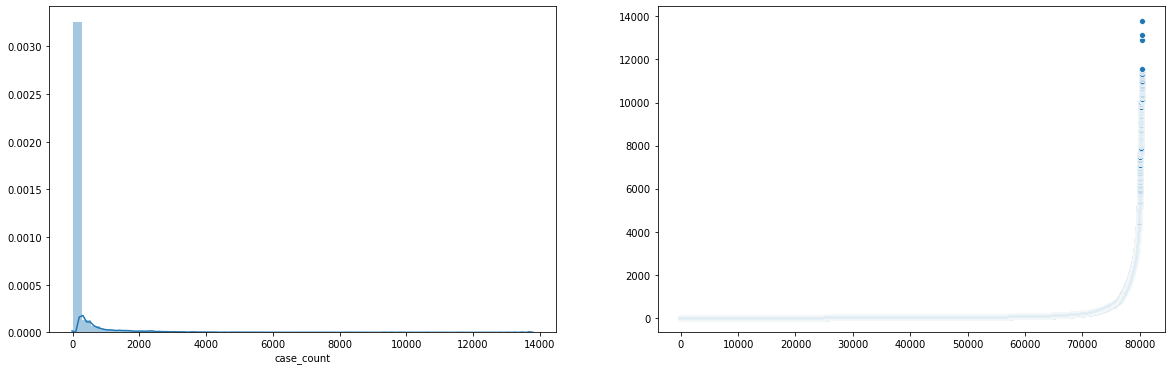

In [ ]:
plt.subplot(1,2,1)
sns.distplot(train_data_og.case_count) 
plt.subplot(1,2,2)
sns.scatterplot(x = range(0, len(train_data_og.case_count)), y = np.sort(train_data_og.case_count))
plt.show()

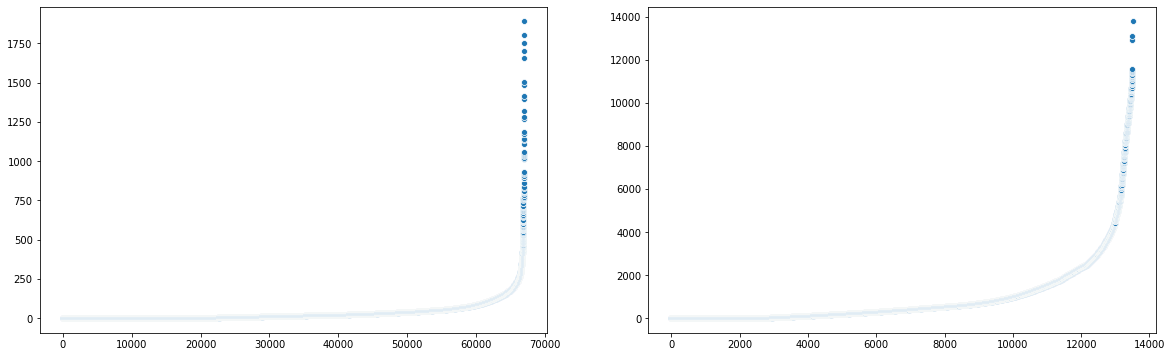

In [ ]:
plt.subplot(1,2,1)
sns.scatterplot(x = range(0, len(train_data_og.query('segment == 1').case_count)), y = np.sort(train_data_og.query('segment == 1').case_count))
plt.subplot(1,2,2)
sns.scatterplot(x = range(0, len(train_data_og.query('segment == 2').case_count)), y = np.sort(train_data_og.query('segment == 2').case_count))
plt.show()

### Univariate

Distributions, Outliers

No handles with labels found to put in legend.


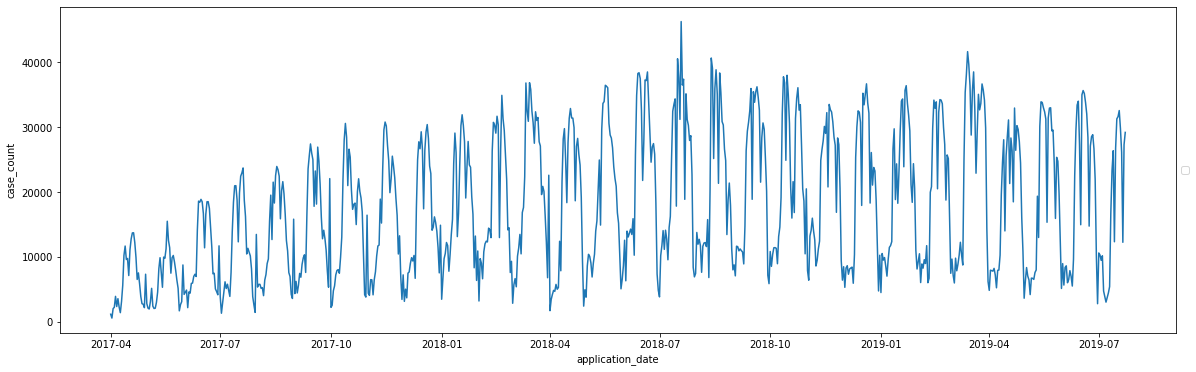

In [ ]:
# By date
# plt.subplot(1,2,1)
sns.lineplot(x = "application_date", y = "case_count", data = train_data_og.groupby(['application_date'])[['case_count']].sum().reset_index(), ci=False)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
# plt.subplot(1,2,2)
# sns.lineplot(x = "application_date", y = "id", data = sub_data_og, ci = False)
plt.show()

In [ ]:
# All this points should be stabalised because things have improved now- after 2018 11 why the trend did'nt continue?
# Add features such as last day, second last day, third last day. etc for segment one
train_data_og.query('segment == 2').groupby(['application_date'])[['case_count']].sum().reset_index().query('case_count > 30000')

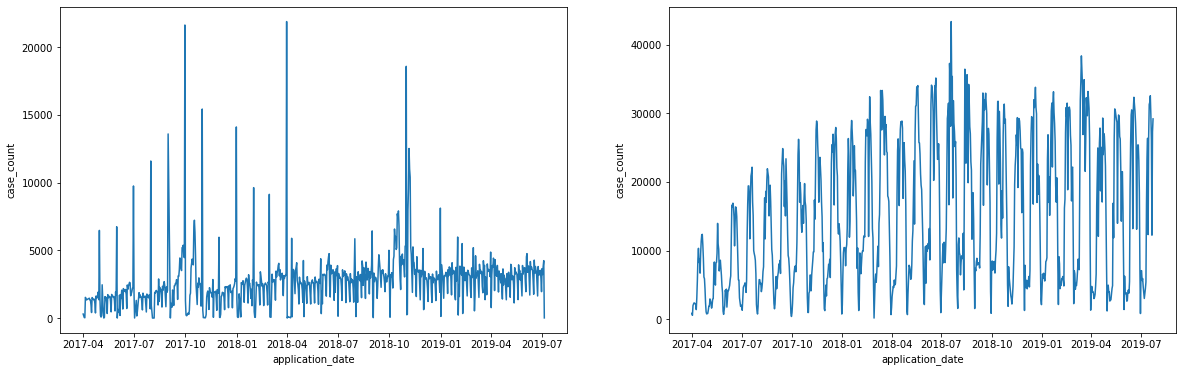

In [ ]:
# By date
plt.subplot(1,2,1)
sns.lineplot(x = "application_date", y = "case_count", data = train_data_og.query('segment == 1').groupby(['application_date'])[['case_count']].sum().reset_index(), ci=False)
plt.subplot(1,2,2)
sns.lineplot(x = "application_date", y = "case_count", data = train_data_og.query('segment == 2').groupby(['application_date'])[['case_count']].sum().reset_index(), ci=False)
plt.show()

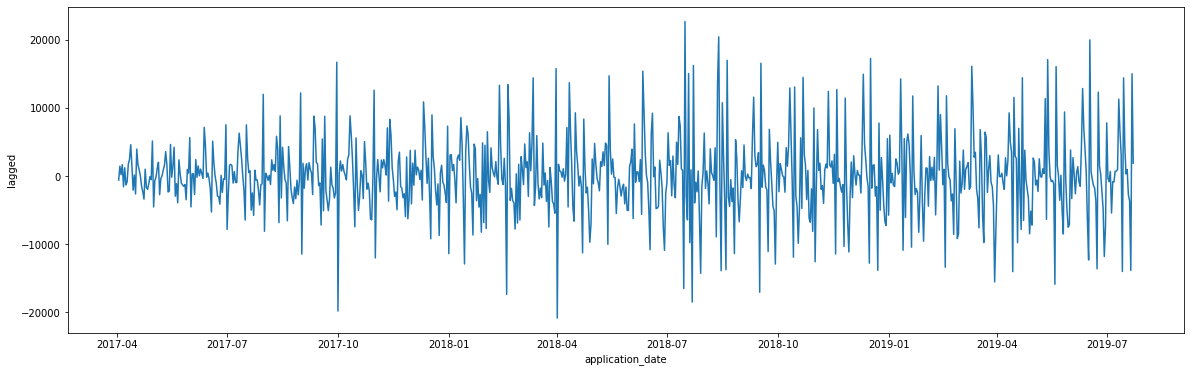

In [ ]:
gde = train_data_og.groupby(['application_date'])[['case_count']].sum().reset_index()
sns.lineplot(x = 'application_date',y = 'lagged', data = gde.assign(lagged = gde.case_count - gde.case_count.shift(1)))
plt.show()

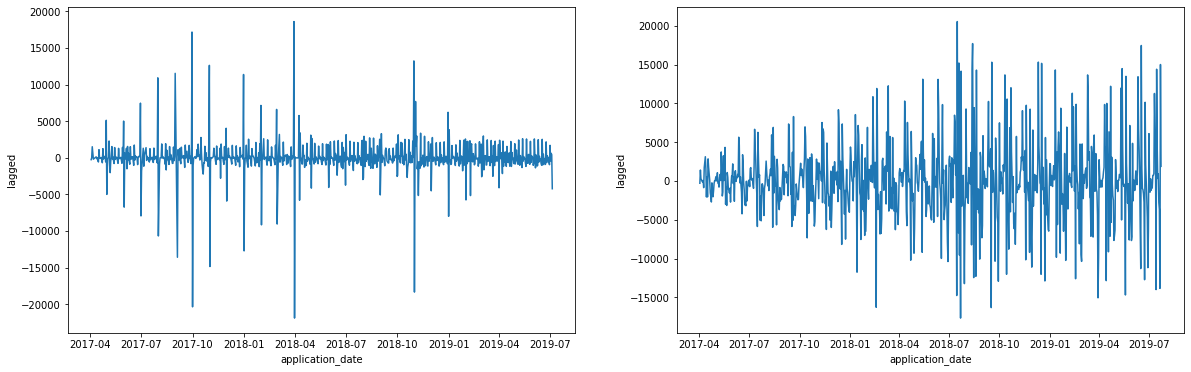

In [ ]:
plt.subplot(1,2,1)
gde = train_data_og.query('segment == 1').groupby(['application_date'])[['case_count']].sum().reset_index()
sns.lineplot(x = 'application_date',y = 'lagged', data = gde.assign(lagged = gde.case_count - gde.case_count.shift(1)))
plt.subplot(1,2,2)
gde = train_data_og.query('segment == 2').groupby(['application_date'])[['case_count']].sum().reset_index()
sns.lineplot(x = 'application_date',y = 'lagged', data = gde.assign(lagged = gde.case_count - gde.case_count.shift(1)))
plt.show()

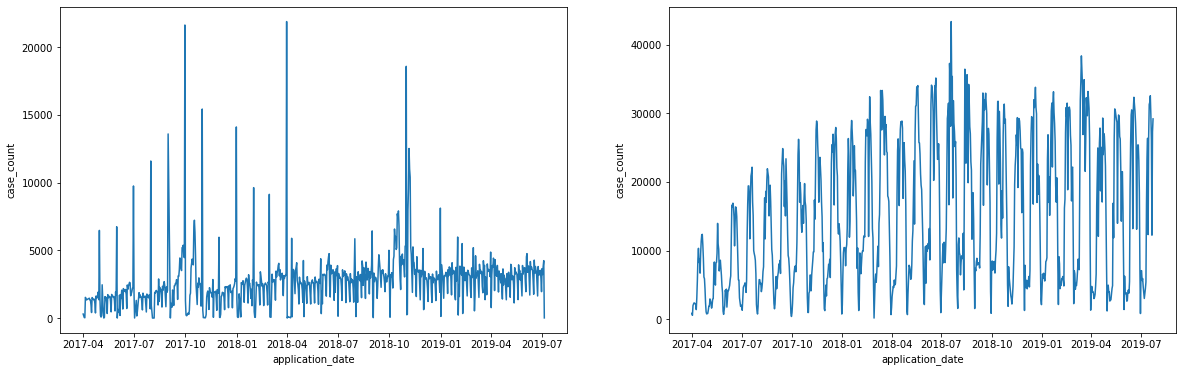

In [ ]:
# By date
plt.subplot(1,2,1)
sns.lineplot(x = "application_date", y = "case_count", data = train_data_og.query('segment == 1').groupby(['application_date'])[['case_count']].sum().reset_index(), ci=False)
plt.subplot(1,2,2)
sns.lineplot(x = "application_date", y = "case_count", data = train_data_og.query('segment == 2').groupby(['application_date'])[['case_count']].sum().reset_index(), ci=False)
plt.show()

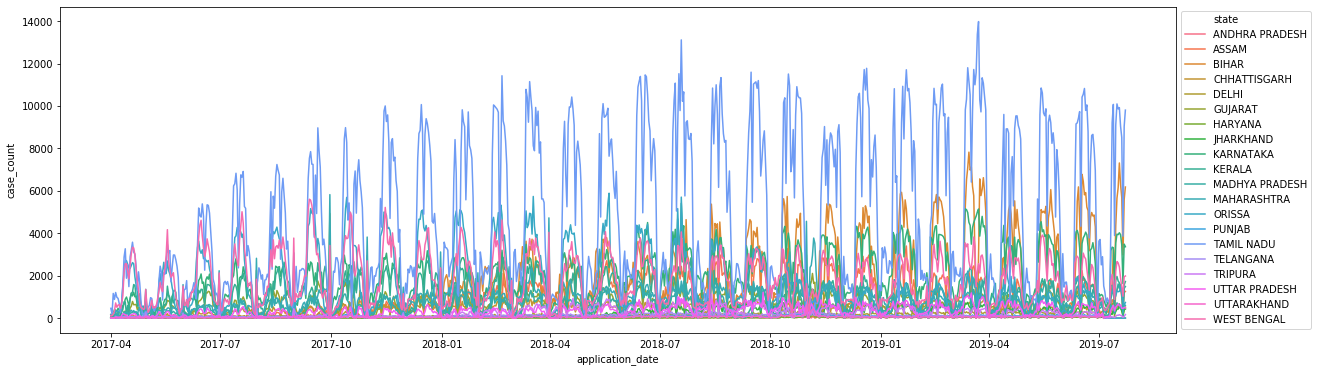

In [ ]:
# By date
# plt.subplot(1,2,1)
sns.lineplot(x = "application_date", y = "case_count", hue = "state", data = train_data_og.groupby(['application_date', 'state'])[['case_count']].sum().reset_index(), ci=False)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
# plt.subplot(1,2,2)
# sns.lineplot(x = "application_date", y = "id", data = sub_data_og, ci = False)
plt.show()

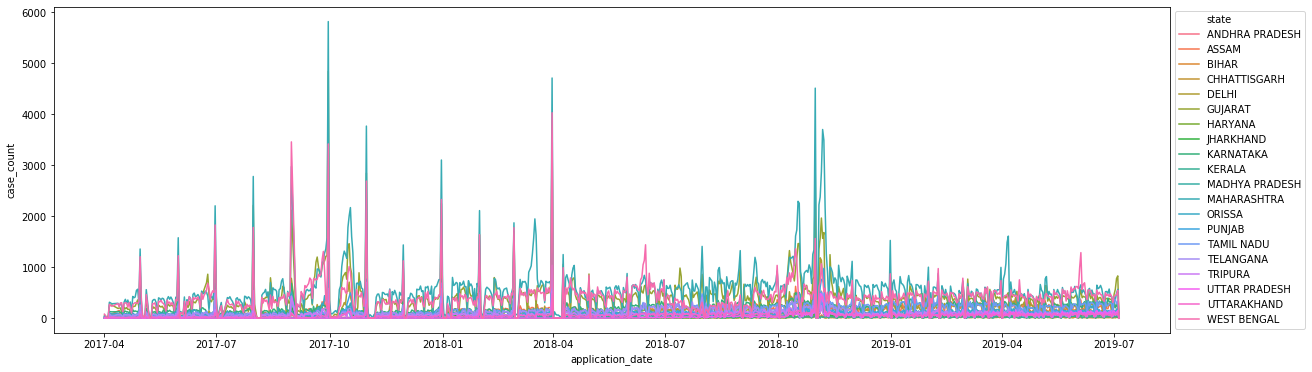

In [ ]:
# By date
# plt.subplot(1,2,1)
sns.lineplot(x = "application_date", y = "case_count", hue = "state", data = train_data_og.query('segment == 1').groupby(['application_date', 'state'])[['case_count']].sum().reset_index(), ci=False)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
# plt.subplot(1,2,2)
# sns.lineplot(x = "application_date", y = "id", data = sub_data_og, ci = False)
plt.show()

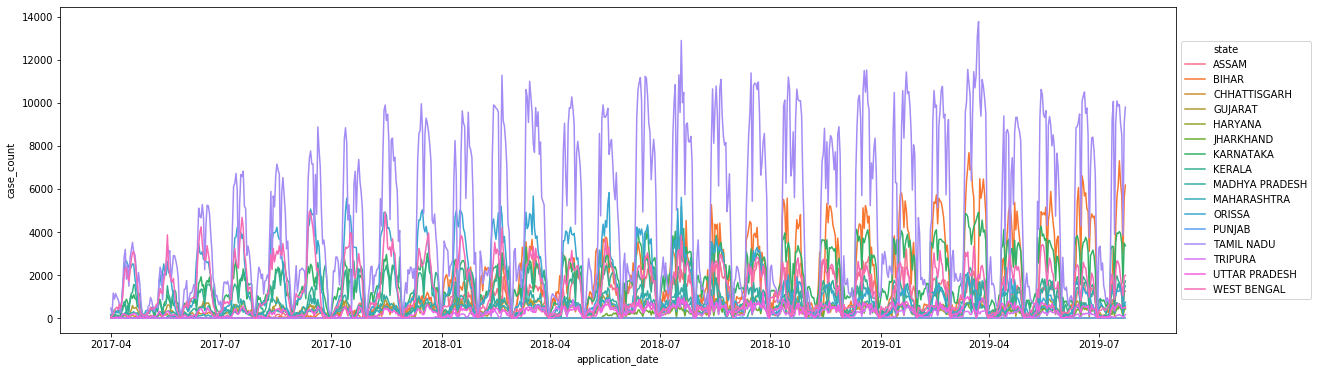

In [ ]:
# By date
# plt.subplot(1,2,1)
sns.lineplot(x = "application_date", y = "case_count", hue = "state", data = train_data_og.query('segment == 2').groupby(['application_date', 'state'])[['case_count']].sum().reset_index(), ci=False)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
# plt.subplot(1,2,2)
# sns.lineplot(x = "application_date", y = "id", data = sub_data_og, ci = False)
plt.show()

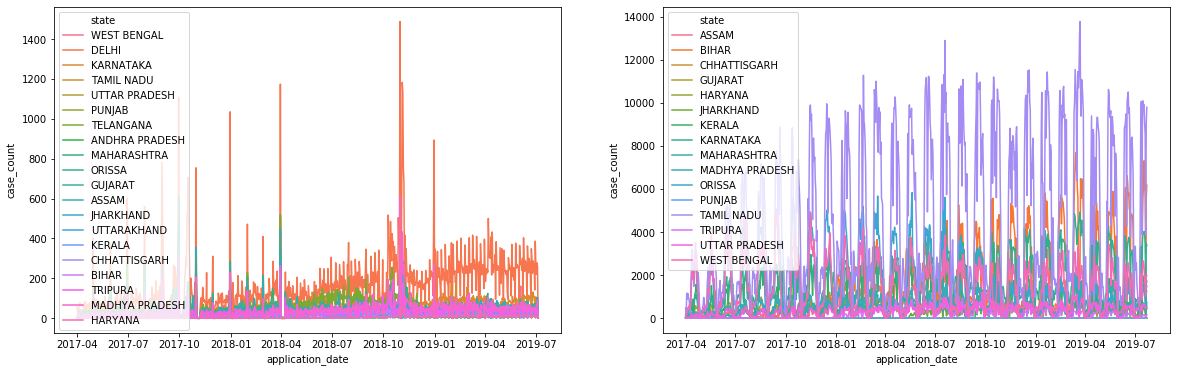

In [ ]:
# By date
plt.subplot(1,2,1)
sns.lineplot(x = "application_date", y = "case_count", hue = "state",  data = train_data_og.query("segment == 1"), ci=False)
plt.subplot(1,2,2)
sns.lineplot(x = "application_date", y = "case_count", hue = "state", data = train_data_og.query("segment == 2"), ci = False)
plt.show()

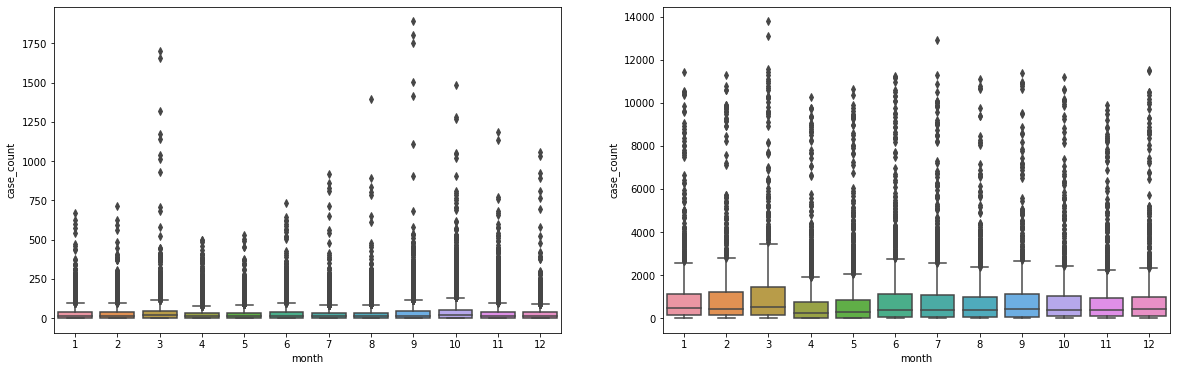

In [ ]:
s# By month
plt.subplot(1,2,1)
sns.boxplot(x = "month", y = "case_count", data = train_data_og.assign(month = train_data_og.application_date.dt.month).query("segment == 1"))
plt.subplot(1,2,2)
sns.boxplot(x = "month", y = "case_count", data = train_data_og.assign(month = train_data_og.application_date.dt.month).query("segment == 2"))
plt.show()

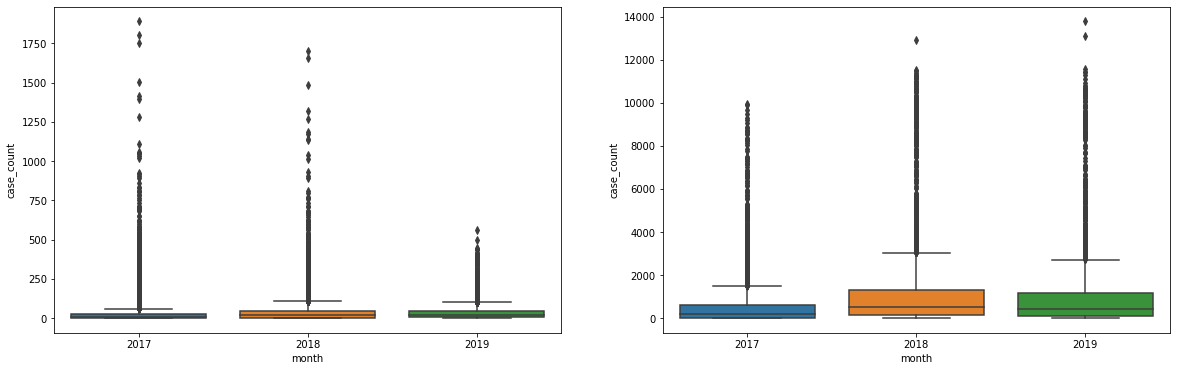

In [ ]:
# By month
plt.subplot(1,2,1)
sns.boxplot(x = "month", y = "case_count", data = train_data_og.assign(month = train_data_og.application_date.dt.year).query("segment == 1"))
plt.subplot(1,2,2)
sns.boxplot(x = "month", y = "case_count", data = train_data_og.assign(month = train_data_og.application_date.dt.year).query("segment == 2"))
plt.show()

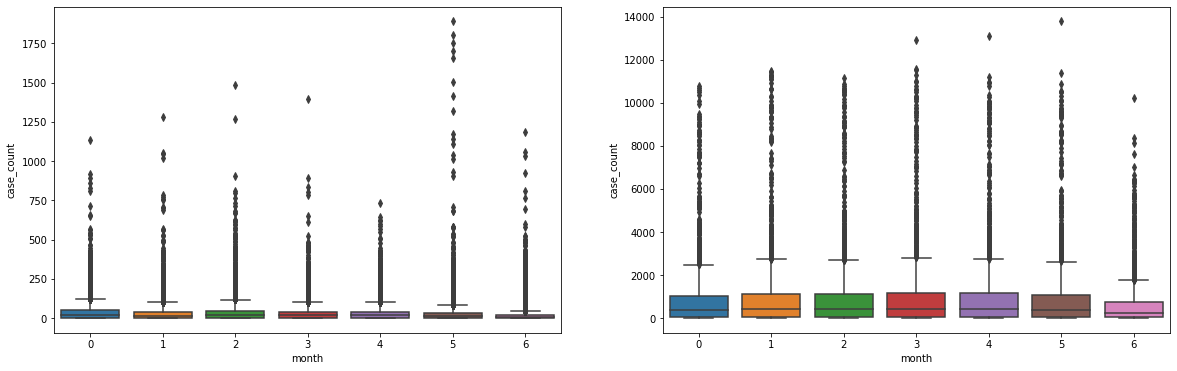

In [ ]:
# By weekday
plt.subplot(1,2,1)
sns.boxplot(x = "month", y = "case_count", data = train_data_og.assign(month = train_data_og.application_date.dt.weekday).query("segment == 1"))
plt.subplot(1,2,2)
sns.boxplot(x = "month", y = "case_count", data = train_data_og.assign(month = train_data_og.application_date.dt.weekday).query("segment == 2"))
plt.show()

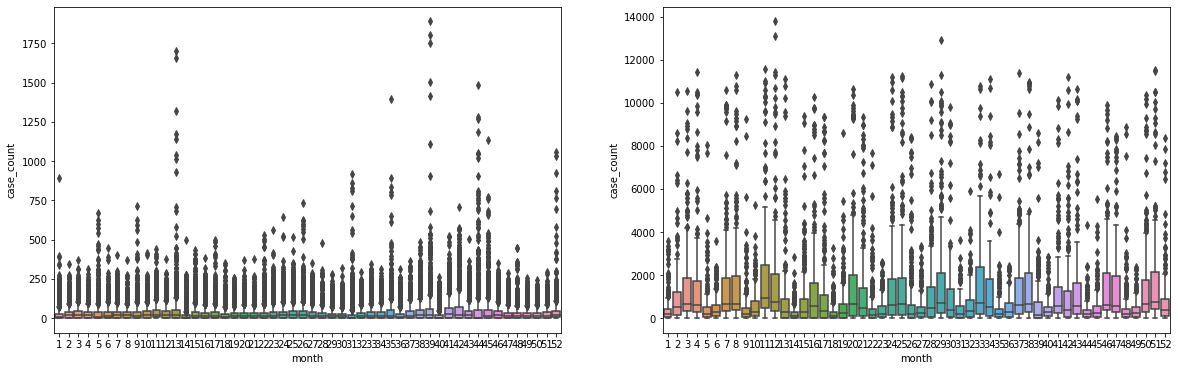

In [ ]:
# By week of the year
plt.subplot(1,2,1)
sns.boxplot(x = "month", y = "case_count", data = train_data_og.assign(month = train_data_og.application_date.dt.week).query("segment == 1"))
plt.subplot(1,2,2)
sns.boxplot(x = "month", y = "case_count", data = train_data_og.assign(month = train_data_og.application_date.dt.week).query("segment == 2"))
plt.show()

SEE LAG VALUES, MA etc

**lags 365 shows clear pattern in segment 2**

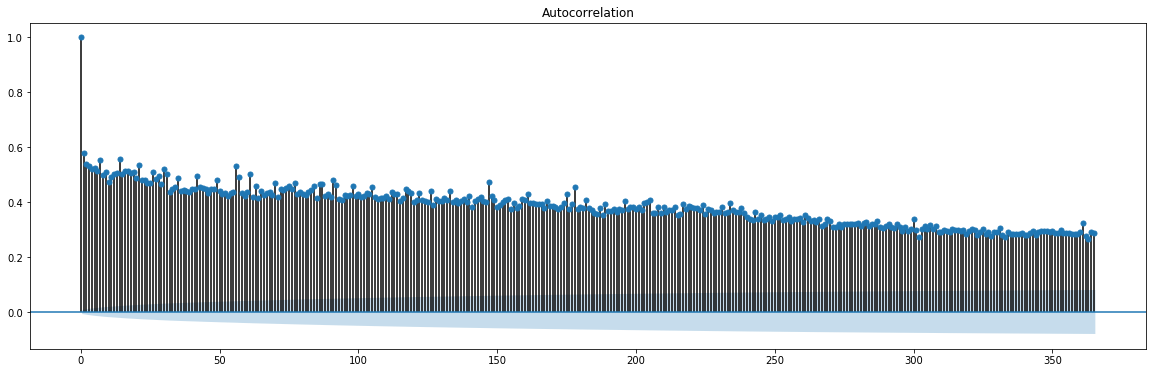

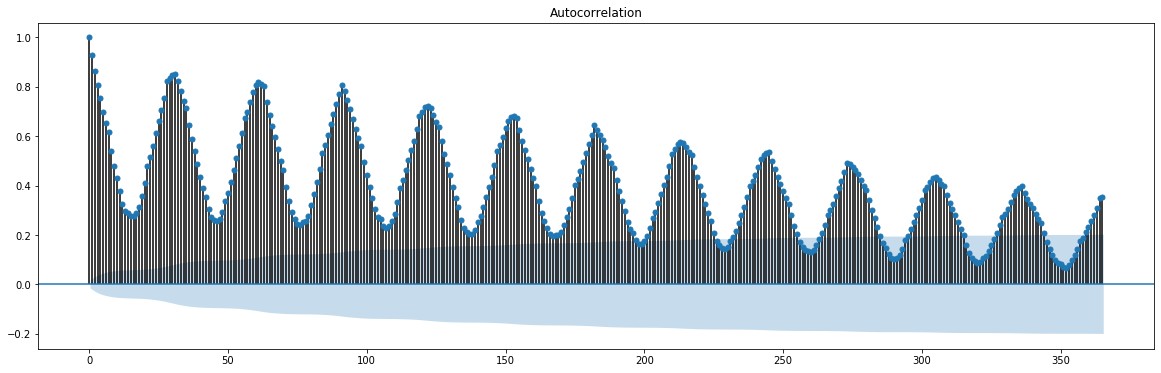

In [ ]:
#plt.subplot(1,2,1)
plot_acf(train_data_og.assign(month = train_data_og.application_date.dt.month).query("segment == 1").case_count, lags = 365)
#plt.subplot(1,2,2)
plt.show()
plot_acf(train_data_og.assign(month = train_data_og.application_date.dt.month).query("segment == 2").case_count, lags = 365)
plt.show()

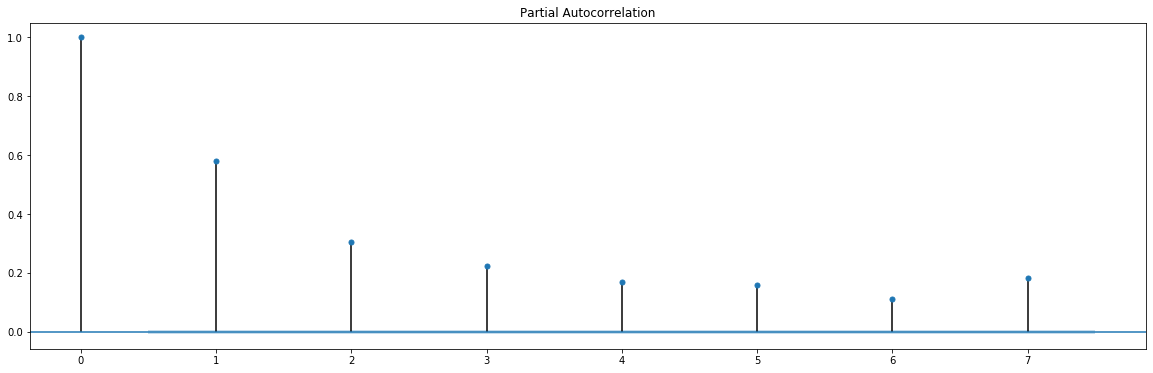

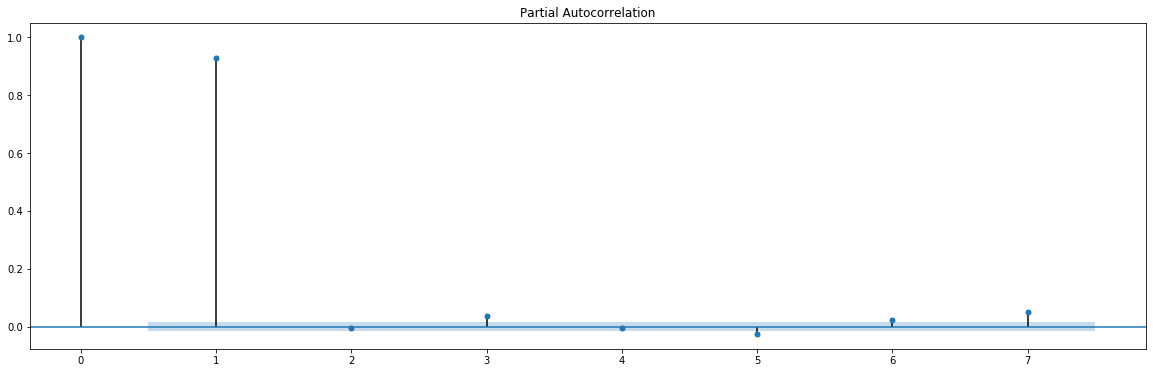

In [ ]:
#plt.subplot(1,2,1)
plot_pacf(train_data_og.assign(month = train_data_og.application_date.dt.month).query("segment == 1").case_count, lags = 7)
# plt.subplot(1,2,2)
plot_pacf(train_data_og.assign(month = train_data_og.application_date.dt.month).query("segment == 2").case_count, lags = 7)
plt.show()

As of now do not use state

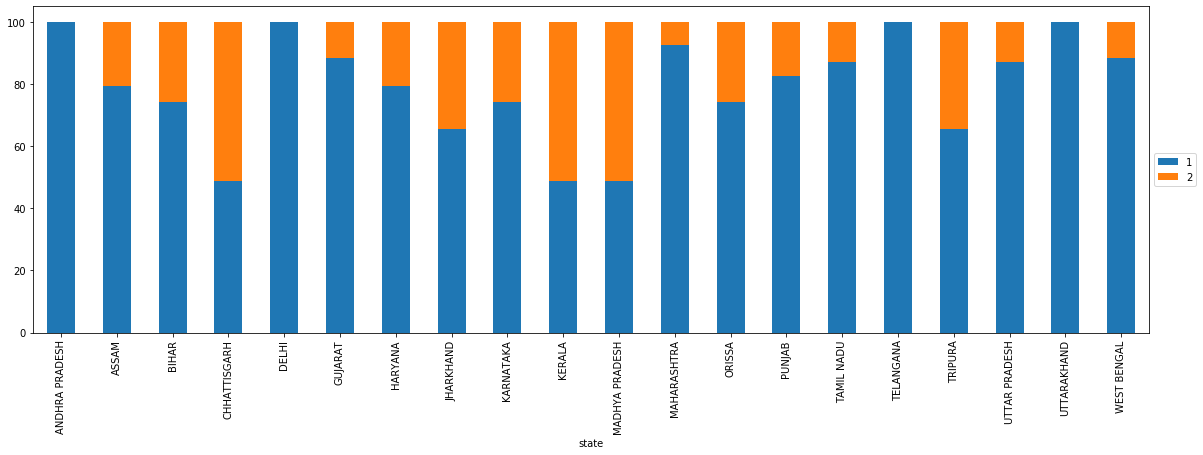

In [ ]:
pd.crosstab(train_data_og.state, train_data_og.segment).apply(lambda r: r/r.sum()*100, axis=1).plot.bar(stacked=True, rot=0)
plt.xticks(rotation = 90)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()

### Bivariate

Comparision, corelation

In [ ]:
plt.subplot(1,2,1)
sns.countplot(train_data.XXX, order = train_data.xxx.values_count().index )
plt.subplot(1,2,2)
sns.countplot(sub_data.XXX, order = [1,2,3,4])
plt.show()

### With sub_data

Submit pattern, cv on, splitted on

## Data Validation

Replace xxx with proper data  

1) Random split
2) Catogorical split
3) Time based split

1650 rows = Segment 1 + Segment 2  
806 rows = Segment 1  


In [ ]:
train_data_me.query("segment == 2").isna().sum()

In [ ]:
X_s1 = train_data_me.drop(['case_count', 'application_date'], axis = 1).query('segment == 1')
X_sub_s1 = sub_data_me.query('segment == 1')
y_s1 = train_data_me.query('segment == 1')["case_count"]

# THIS CANNOT BE USED AS SEGMENT 2 is at the end!!!!!!
X_train_s1 = X_s1.iloc[0:50000,:]
X_test_s1 = X_s1.iloc[50000:,:]

y_train_s1 = y_s1.iloc[0:50000]
y_test_s1 = y_s1.iloc[50000:]

In [ ]:
print("Train set rows %s, cols %s and y is %s" % (X_train_s1.shape[0], X_train_s1.shape[1], y_train_s1.shape[0]))
print("Test set rows %s, cols %s and y is %s" % (X_test_s1.shape[0], X_test_s1.shape[1], y_test_s1.shape[0]))
print("Submission set rows %s, cols %s and y is to be predicted" % (X_sub_s1.shape[0], X_sub_s1.shape[1]))

Train set rows 50000, cols 20 and y is 50000
Test set rows 16898, cols 20 and y is 16898
Submission set rows 722100, cols 22 and y is to be predicted


In [ ]:
#X_s2 = train_data_me.drop(['case_count', 'application_date', 'zone_sum', 'zone_mean', 'zone_count', 'zone_std', 'branch_mean', 'branch_std', 'branch_sum', 'branch_count'], axis = 1).query('segment == 2')
X_s2 = train_data_me.drop(['case_count', 'application_date', 'zone_mean', 'zone_count', 'branch_mean', 'branch_count'], axis = 1).query('segment == 2')
X_sub_s2 = sub_data_me.drop(['zone_mean', 'zone_count', 'branch_mean', 'branch_count'], axis = 1).query('segment == 2')
y_s2 = train_data_me.query('segment == 2')["case_count"]

# THIS CANNOT BE USED AS SEGMENT 2 is at the end!!!!!!
X_train_s2 = X_s2.iloc[0:10000,:]
X_test_s2 = X_s2.iloc[10000:,:]

y_train_s2 = y_s2.iloc[0:10000]
y_test_s2 = y_s2.iloc[10000:]

In [ ]:
print("Train set rows %s, cols %s and y is %s" % (X_train_s2.shape[0], X_train_s2.shape[1], y_train_s2.shape[0]))
print("Test set rows %s, cols %s and y is %s" % (X_test_s2.shape[0], X_test_s2.shape[1], y_test_s2.shape[0]))
print("Submission set rows %s, cols %s and y is to be predicted" % (X_sub_s2.shape[0], X_sub_s2.shape[1]))

Train set rows 10000, cols 16 and y is 10000
Test set rows 3504, cols 16 and y is 3504
Submission set rows 1488, cols 18 and y is to be predicted


In [ ]:
# # Run only if required

# for x in set(X_train.columns) - set(X_sub.columns) :
#     X_sub[x] = 0

# X_sub = X_sub[X.columns]
    
# print("Submission set rows %s, cols %s and y is to be predicted" % (X_sub.shape[0], X_sub.shape[1]))

### Validataion EDA

## Modeling

For Regression verify distribution.  
For Classification verify confusion matrix.  
Use 10 fold cross validation to verify final model.  

### Submission Part

Ensure that model is trained on whole set

### XGBoost

Monitor metric performance on both train and test.  

In [ ]:
# xgb.XGBRegressor or xgb.XGBClassifier
xgb_model_s1 = xgb.XGBRegressor(n_estimators=1000) # learning_rate=0.01, scale_pos_weight = weight, n_estimators = 100000
xgb_model_s1.fit(X_train_s1, y_train_s1, eval_metric = "rmse", eval_set = [(X_train_s1, y_train_s1), (X_test_s1, y_test_s1)], verbose = 1000, early_stopping_rounds=10)

[0]	validation_0-rmse:75.0105	validation_1-rmse:13.5432
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


Stopping. Best iteration:
[13]	validation_0-rmse:48.0826	validation_1-rmse:11.1613



XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

In [ ]:
# https://stackoverflow.com/questions/37436629/how-to-write-a-custom-evaluation-metric-in-python-for-xgboost
def mape_vectorized_v2(a, b): 
    mask = a != 0
    return (np.fabs(a - b)/a)[mask].mean() 

In [ ]:
mape_vectorized_v2(y_train_s1, xgb_model_s1.predict(X_train_s1))

1.1620864939650615

In [ ]:
mape_vectorized_v2(y_test_s1, xgb_model_s1.predict(X_test_s1))

1.018557042184673

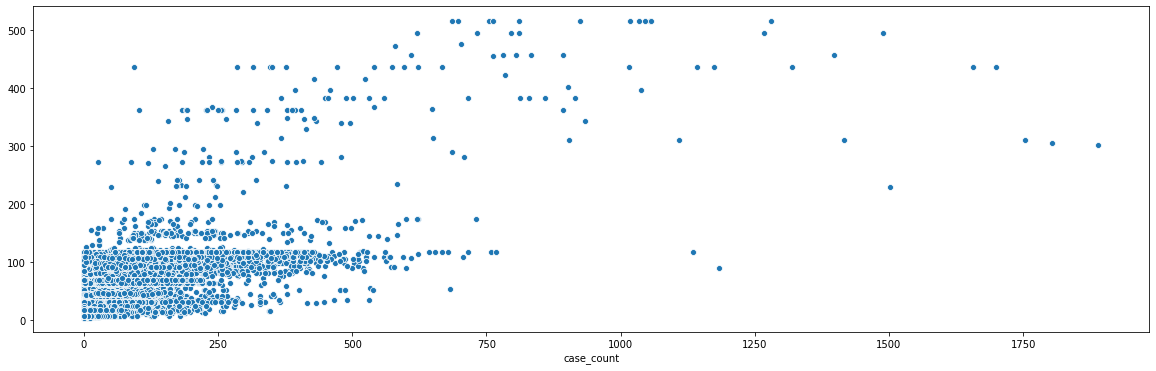

In [ ]:
sns.scatterplot(y_train_s1, xgb_model_s1.predict(X_train_s1))
plt.show()

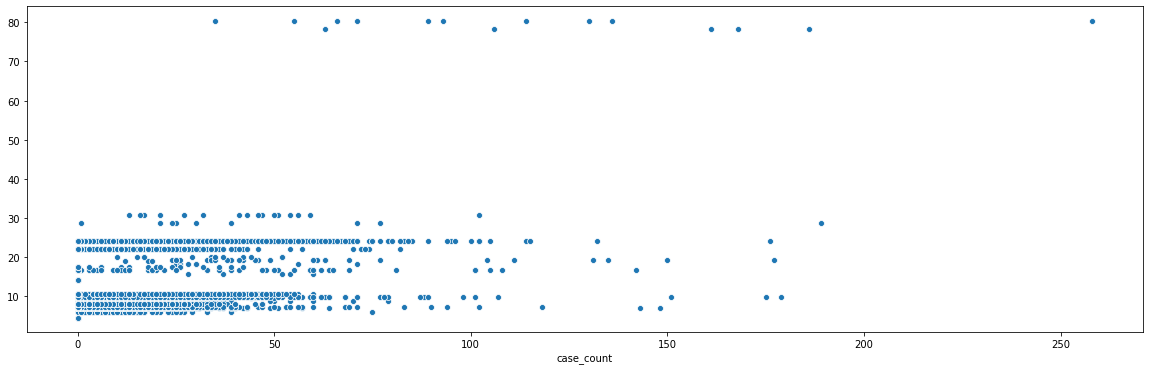

In [ ]:
sns.scatterplot(y_test_s1, xgb_model_s1.predict(X_test_s1))
plt.show()

In [ ]:
pd.DataFrame({"Actual" : y_test_s1, "Pred" : xgb_model_s1.predict(X_test_s1)})

,Actual,Pred
50000,13.0,7.149702
50001,2.0,7.149702
50002,0.0,7.149702
50003,0.0,7.149702
50004,8.0,7.149702
50005,8.0,7.149702
50006,5.0,7.149702
50007,8.0,7.149702
50008,1.0,7.149702
50009,9.0,7.149702


In [ ]:
# groups = X_train[["Transmission", "Fuel_Type_CNG", "Fuel_Type_Diesel", "Fuel_Type_Electric", "Fuel_Type_LPG", "Fuel_Type_Petrol"]]

# cross_val_score(xgb_model, X_train, y_train, cv = 5, groups = groups) # Add Fuel Type as well

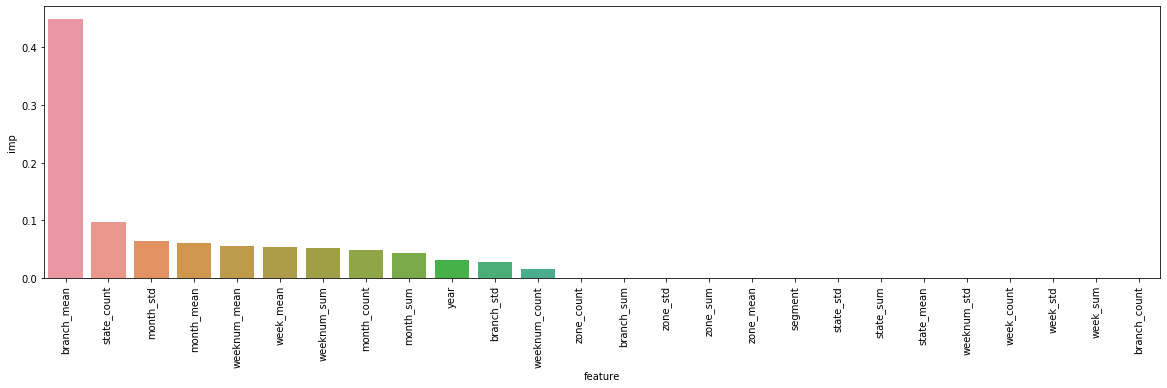

In [ ]:
plt.figure(figsize = (20, 5))
sns.barplot("feature", "imp", data = pd.DataFrame( {'feature' : X_train_s1.columns, 'imp' : xgb_model_s1.feature_importances_ }).sort_values("imp", ascending = False) )
plt.xticks(rotation = 90)
plt.show()

In [ ]:
# xgb.XGBRegressor or xgb.XGBClassifier
xgb_model_s2 = xgb.XGBRegressor(n_estimators=1000) # learning_rate=0.01, scale_pos_weight = weight, n_estimators = 100000
xgb_model_s2.fit(X_train_s2, y_train_s2, eval_metric = "rmse", eval_set = [(X_train_s2, y_train_s2), (X_test_s2, y_test_s2)], verbose = 1000, early_stopping_rounds=10)

[0]	validation_0-rmse:1151.5	validation_1-rmse:2952.5
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


Stopping. Best iteration:
[93]	validation_0-rmse:523.164	validation_1-rmse:2024.69



XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

In [ ]:
mape_vectorized_v2(y_train_s2, xgb_model_s2.predict(X_train_s2))

1.6344606428884194

In [ ]:
mape_vectorized_v2(y_test_s2, xgb_model_s2.predict(X_test_s2))

1.386882616492079

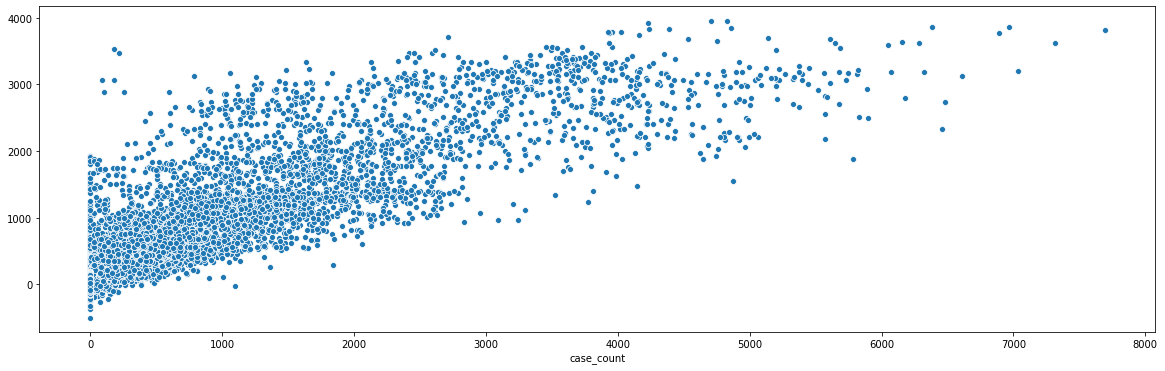

In [ ]:
sns.scatterplot(y_train_s2, xgb_model_s2.predict(X_train_s2))
plt.show()

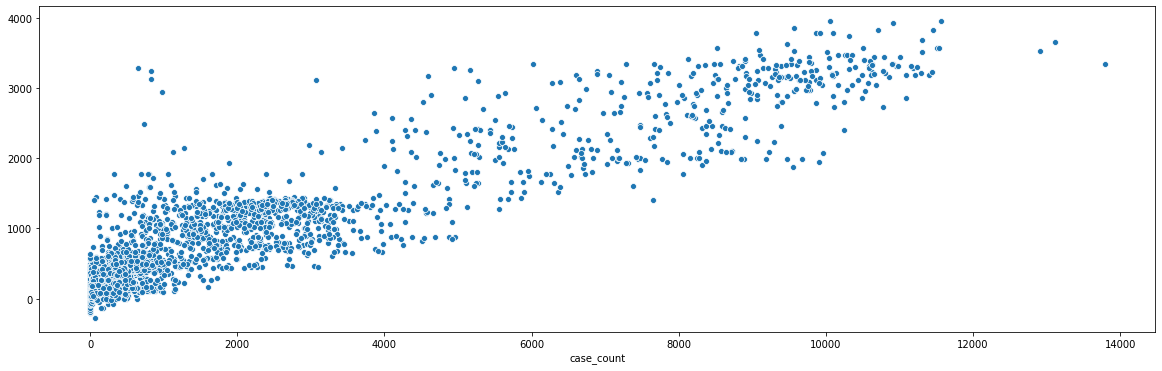

In [ ]:
sns.scatterplot(y_test_s2, xgb_model_s2.predict(X_test_s2))
plt.show()

In [ ]:
pd.DataFrame({"Actual" : y_test_s2, "Pred" : xgb_model_s2.predict(X_test_s2)})

,Actual,Pred
76898,0.0,67.404045
76899,0.0,48.089020
76900,0.0,51.800415
76901,0.0,45.126572
76902,0.0,27.523449
76903,0.0,60.842361
76904,0.0,-77.738350
76905,0.0,222.949066
76906,0.0,192.029160
76907,0.0,184.120071


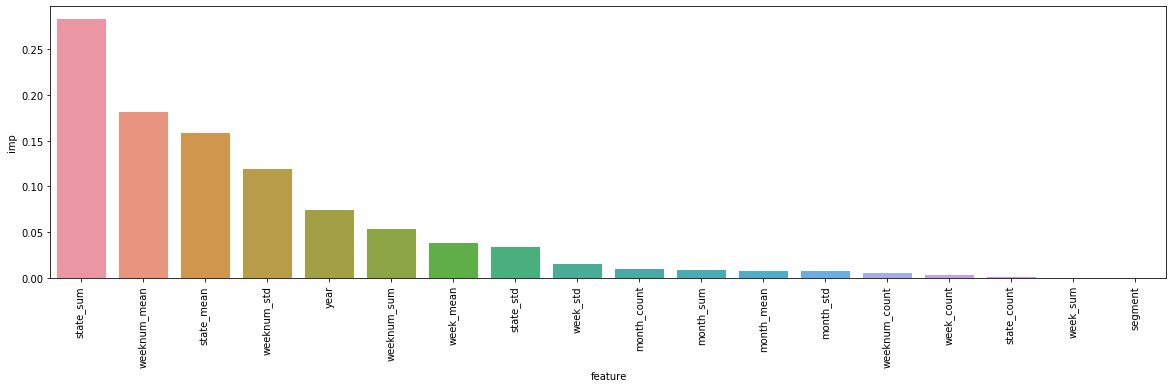

In [ ]:
plt.figure(figsize = (20, 5))
sns.barplot("feature", "imp", data = pd.DataFrame( {'feature' : X_train_s2.columns, 'imp' : xgb_model_s2.feature_importances_ }).sort_values("imp", ascending = False) )
plt.xticks(rotation = 90)
plt.show()

Final score = 05 * segment 1 + 0.5 * segment 2

In [ ]:
.50 * mape_vectorized_v2(y_train_s1, xgb_model_s1.predict(X_train_s1)) + .50 * mape_vectorized_v2(y_train_s2, xgb_model_s2.predict(X_train_s2))
# 4140.190724094409

1.2268852162645016

In [ ]:
.50 * mape_vectorized_v2(y_test_s1, xgb_model_s1.predict(X_test_s1)) + .50 * mape_vectorized_v2(y_test_s2, xgb_model_s2.predict(X_test_s2))
# 4140.190724094409

1.1155043933473554

In [ ]:
out1 = xgb_model_s1.predict(X_sub_s1.drop(['id','application_date'], axis = 1))
out2 = xgb_model_s2.predict(X_sub_s2.drop(['id','application_date'], axis = 1))

In [ ]:
X_sub_s1["case_count"] = out1
#X_sub_s1[['application_date', 'predict']]
result_01 = X_sub_s1.groupby(['id','application_date'])[['case_count']].sum().reset_index().assign(segment = 1)
result_01 = result_01[['id','application_date', 'segment', 'case_count']]
result_01.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,id,application_date,segment,case_count
0,1,2019-07-06,1,242186.765625
1,2,2019-07-07,1,192075.546875
2,3,2019-07-08,1,252251.937500
3,4,2019-07-09,1,252251.937500
4,5,2019-07-10,1,252251.937500


In [ ]:
X_sub_s2["case_count"] = out2
# X_sub_s2[['application_date', 'predict']]
result_02 = X_sub_s2.groupby(['id','application_date'])[['case_count']].sum().reset_index().assign(segment = 2)
result_02 = result_02[['id','application_date', 'segment', 'case_count']]
result_02.head()

,id,application_date,segment,case_count
0,88,2019-07-24,2,17567.150391
1,89,2019-07-25,2,17475.539062
2,90,2019-07-26,2,17567.150391
3,91,2019-07-27,2,16784.691406
4,92,2019-07-28,2,11908.869141


In [ ]:
pd.concat([result_01, result_02], axis=0).to_csv("testing1.csv", index = False)

In [ ]:
pd.concat([result_01, result_02], axis=0).head()

,id,application_date,segment,case_count
0,1,2019-07-06,1,242186.765625
1,2,2019-07-07,1,192075.546875
2,3,2019-07-08,1,252251.937500
3,4,2019-07-09,1,252251.937500
4,5,2019-07-10,1,252251.937500


#### SHAP

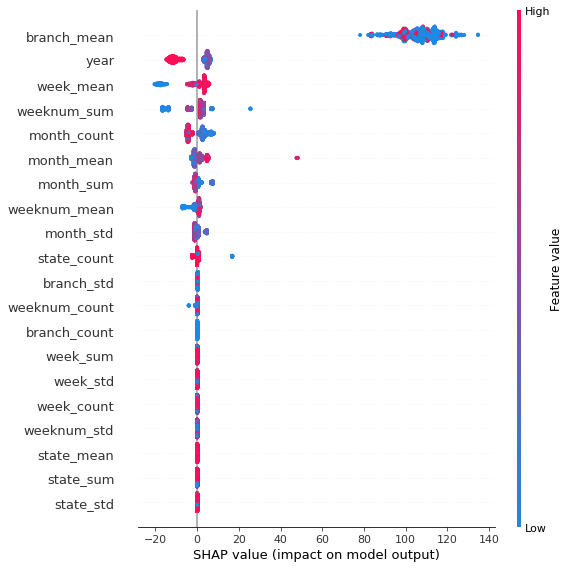

In [ ]:
explainer = shap.TreeExplainer(xgb_model_s1)

nsize = 1000

shap_values = explainer.shap_values(X_train_s1.iloc[0:nsize,:])
shap.summary_plot(shap_values, X_train_s1.iloc[0:nsize,:])

plt.show()

/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:3405: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)


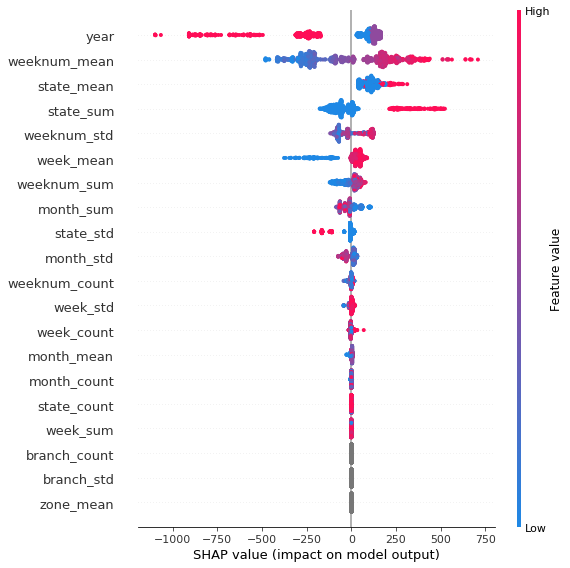

In [ ]:
explainer = shap.TreeExplainer(xgb_model_s2)

nsize = 1000

shap_values = explainer.shap_values(X_train_s2.iloc[0:nsize,:])
shap.summary_plot(shap_values, X_train_s2.iloc[0:nsize,:])

plt.show()

#### Hyperparameter Tuning

Draw appropriate graph to understand impact of two hyperparameters.  
eg: rounds to maxdepth can give an idea where it overfits.

##### GridSearchCV

In [ ]:
cv= RepeatedKFold(2, 2)
xgb_engine = xgb.XGBRegressor() #n_estimator not used
xgb_params = {'booster' : ['gbtree'],
              'max_depth' : [3, 4], 
              'gamma' : [0], 
              'learning_rate' : [0.3], 
              "n_estimators" : [100000], 
              'min_child_weight' : [5, 10], 
              'subsample' : [1], 
              'colsample_bytree' : [0.7, 1], 
              'colsample_bylevel' : [1], 
              'colsample_bynode' : [1], 
              'reg_lambda' : [0], 
              'reg_alpha' : [0]}

xgb_grid = GridSearchCV(xgb_engine, xgb_params, cv = cv, n_jobs = 4, verbose = 0, return_train_score  = True)
xgb_grid.fit(X_train, y_train, eval_set = [(X_train, y_train)], early_stopping_rounds=10, verbose = 1000)

#joblib.dump(xgb_grid, "F:/Vasim/Python Stuff/Flight/gridxgboost.sav")

#print( np.sqrt( -cross_val_score(xgb_grid.best_estimator_, X_train, y_train, cv = cv, scoring = "neg_mean_squared_error") ) )
#print( np.sqrt( mean_squared_error(y_test, xgb_grid.predict(X_test)) ) )

##### Skopt

In [ ]:
from skopt.space import Integer, Categorical, Real
from skopt.utils import use_named_args
from skopt import gp_minimize

# set up hyperparameter space
space = [Integer(3, 50, name='max_depth'),
         Integer(8, 200, name='n_estimators'),
         Integer(3, 50, name='min_child_weight'),
         Real(0.001, 1.0, name='learning_rate')]

regressor = xgb.XGBRegressor()

from sklearn.model_selection import cross_val_score

@use_named_args(space)
def objective(**params):
    regressor.set_params(**params)
    return -np.mean(cross_val_score(regressor, X_train, y_train, cv=5, n_jobs=1, scoring='neg_mean_squared_error'))

In [ ]:
reg_gp = gp_minimize(objective, space, verbose=False)

print('best score: {}'.format(reg_gp.fun))

print('best params:')
print('        max_depth: {}'.format(reg_gp.x[0]))
print('     n_estimators: {}'.format(reg_gp.x[1]))
print(' min_child_weight: {}'.format(reg_gp.x[2]))
print('    learning_rate: {}'.format(reg_gp.x[3]))

In [ ]:
import skopt.plots
skopt.plots.plot_convergence(reg_gp)

In [ ]:
skopt.plots.plot_evaluations(reg_gp, bins = 20)
plt.show()

In [ ]:
skopt.plots.plot_objective(reg_gp)
plt.show()

##### Hyperopt

### LightGBM
Inbuilt Categorical features

In [ ]:
lgbm_model = lgb.LGBMRegressor(learning_rate=0.01, n_estimators=100000)
lgbm_model.fit(X_train, y_train, eval_set = [(X_test, y_test)], early_stopping_rounds=100, verbose = 1000)

#### SHAP

In [ ]:
explainer = shap.TreeExplainer(lgbm_model)

nsize = 1000

shap_values = explainer.shap_values(X_train.iloc[0:nsize,:])
shap.summary_plot(shap_values, X_train.iloc[0:nsize,:])

plt.show()

#### Hyperparamter Tuning

In [ ]:
lgbm_engine = lgb.LGBMRegressor()
lgbm_params = {'max_depth' : [17], 'learning_rate' : [0.05], 'n_estimators': [100000],  'min_child_samples' : [3], 'num_leaves' : [40], 'min_child_weight' : [0.001], 
               'min_split_gain' : [0], 'colsample_bytree' : [0.3], 'reg_alpha' : [0], 'reg_lamba' : [0], 'importance_type' : ['split'] }

lgbm_grid = GridSearchCV(lgbm_engine, lgbm_params, cv = 4, n_jobs = 4, verbose = 0)
lgbm_grid.fit(X_train, y_train, eval_set = [(X_test, y_test)], early_stopping_rounds=100, verbose = 1000)
#print( np.sqrt( -cross_val_score(lgbm_grid.best_estimator_, X_train, y_train, cv = 5, scoring = "neg_mean_squared_error") ) )
#print( np.sqrt( mean_squared_error(y_test, lgbm_grid.predict(X_test)) ) )

### CatBoost

Inbuilt Categorical features  

The cat.cv - inbuilt cross validation gives cross validated result on each iterations.   
The only hyperparameter we can select from in built cv is no of iteration.  
Try sklearn cv type with for loop for cv score or skopt or hyperopt module.  

In [ ]:
from catboost import CatBoostRegressor, Pool
categorical_features_indices = np.where(cat_train.dtypes == 'object')[0]

cat_model = CatBoostRegressor(iterations = 100000, learning_rate = 0.01)
cat_model.fit(cat_train, y_train, eval_set = (cat_test, y_test), cat_features = categorical_features_indices, plot = True, verbose = 1000, early_stopping_rounds=100)

#print( np.sqrt( -cross_val_score(cat_model, X_train, y_train, cv = 5, scoring = "neg_mean_squared_error", verbose = False) ) )
#np.sqrt(mean_squared_error(y_test, cat_model.predict(X_test)))

#### SHAP

In [ ]:
explainer = shap.TreeExplainer(cat_model)

nsize = 1000

shap_values = explainer.shap_values(X_train.iloc[0:nsize,:])
shap.summary_plot(shap_values, X_train.iloc[0:nsize,:])

plt.show()

#### Hyperparamter Tuning

In [ ]:
cat_engine = CatBoostRegressor()
cat_params = {'max_depth' : [4], 'learning_rate' : [0.1], 'iterations': [100000], 'colsample_bylevel' : [1]}
    
cat_grid = GridSearchCV(cat_engine, cat_params, cv = 4, n_jobs = 4, verbose = False)
cat_grid.fit(cat_train, y_train, eval_set = (cat_val, y_val), cat_features = categorical_features_indices, plot = True, verbose = 1000, early_stopping_rounds=100)

### SVM

Apply scaling

In [ ]:
#%%script false

from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler, MinMaxScaler

#Scaling only on numeric data.
svmpipe = Pipeline([ ( "std", StandardScaler() ), ("mimax", MinMaxScaler()) , ( "svm", SVR(gamma = 'scale', kernel = 'rbf', C = 1.5, epsilon = 0.1, max_iter=-1) ) ])
svmpipe.fit(X_train, y_train)

#np.sqrt( -cross_val_score(svmpipe, X_train.astype(float), y_train.astype(float), cv = 5, scoring = "neg_mean_squared_error") )
np.sqrt( mean_squared_error(y_test, svmpipe.predict(X_test))) 

#### SHAP

#### Hyperparamter Tuning

### KNN

Apply scaling

In [ ]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler, normalize, MinMaxScaler

#Scaling on numeric data only
neigh = KNeighborsRegressor(n_neighbors=5)
knnpipe = Pipeline([ ( "std", StandardScaler() ), ("minmax", MinMaxScaler() ), ( "knn", neigh ) ])

#scale data
knnpipe.fit(X_train, y_train) 
print( np.sqrt( -cross_val_score(neigh, X_train, y_train, cv = 5, scoring = "neg_mean_squared_error") ) )
#np.sqrt(mean_squared_error(y_test, neigh.predict(X_test)))

#### SHAP

#### Hyperparamter Tuning

### Keras

Apply scaling

In [ ]:
#!pip install tensorboardcolab
# Apply scaling

from tensorboardcolab import TensorBoardColab, TensorBoardColabCallback
from keras.models import Sequential
from keras.layers import Dense, Dropout
#tbc=TensorBoardColab()

model2 = Sequential()
model2.add(Dense(200, input_dim=X_train.shape[1], kernel_initializer='normal', activation='relu'))
model2.add(Dense(30, kernel_initializer='normal', activation='relu'))
model2.add(Dropout(.10))
#model.add(Dense(10, kernel_initializer='normal', activation='relu'))
#model.add(Dropout(.10))
model2.add(Dense(1, kernel_initializer='normal'))

model2.compile(loss='mean_squared_error', optimizer='adam')

model2.fit(X_train, y_train, epochs = 18, verbose = 0) #callbacks=[TensorBoardColabCallback(tbc)]
pd.DataFrame( {"Actual" : np.exp(y_test), "Predict" : np.exp(model2.predict(X_test)[0:,0])} ).describe()

#### SHAP

#### Hyperparamter Tuning

### Linear

inludes - Logistic  
Panelty - Ridge, Lasso and ElasticNet  


#### SHAP

#### Hyperparamter Tuning

## Stacking

In [ ]:
#mlextend